# Food CNN

In [1]:
import tensorflow as tf
import glob

In [7]:
import pandas as pd 
import os
import numpy as np 
import cv2
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import regularizers, utils

import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data and Augment

In [9]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.1,)

crop_train_generator=datagen.flow_from_directory(
    directory="UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128),
    subset='training')


crop_val_generator=datagen.flow_from_directory(
    directory="UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128),
    
    subset='validation')

Found 10562 images belonging to 100 classes.
Found 1126 images belonging to 100 classes.


## Create Food Classifier

Use transfer learning with InceptionV3 as the base model

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


from tensorflow.keras import models
from tensorflow.keras.layers import Input
import tensorflow as tf

In [11]:
optimizer = Adam(lr = .001)

inception = ResNet50(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy', 'top_k_categorical_accuracy'])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Train Model

In [13]:
history1 = model.fit(crop_train_generator, validation_data= crop_val_generator, epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
331/331 [==============================] - 239s 714ms/step - loss: 4.9772 - accuracy: 0.0712 - top_k_categorical_accuracy: 0.1922 - val_loss: 4.6035 - val_accuracy: 0.0799 - val_top_k_categorical_accuracy: 0.2238
Epoch 2/50
331/331 [==============================] - 227s 685ms/step - loss: 4.2558 - accuracy: 0.1092 - top_k_categorical_accuracy: 0.2655 - val_loss: 4.2887 - val_accuracy: 0.1199 - val_top_k_categorical_accuracy: 0.2620
Epoch 3/50
331/331 [==============================] - 235s 711ms/step - loss: 4.1338 - accuracy: 0.1219 - top_k_categorical_accuracy: 0.3013 - val_loss: 4.2504 - val_accuracy: 0.1208 - val_top_k_categorical_accuracy: 0.2753
Epoch 4/50
331/331 [==============================] - 229s 693ms/step - loss: 4.0787 - accuracy: 0.1308 - top_k_categorical_accuracy: 0.3138 - val_loss: 4.2847 - val_accuracy: 0.1146 - val_top_k_categorical_accuracy: 0.2771
Epoch 5/50
331/331 [==============================] - 216s 652ms/step - loss: 4.0473 - accuracy: 0.1330 

331/331 [==============================] - 199s 601ms/step - loss: 3.6666 - accuracy: 0.1941 - top_k_categorical_accuracy: 0.4161 - val_loss: 4.0008 - val_accuracy: 0.1412 - val_top_k_categorical_accuracy: 0.3357
Epoch 38/50
331/331 [==============================] - 199s 601ms/step - loss: 3.6731 - accuracy: 0.1756 - top_k_categorical_accuracy: 0.4144 - val_loss: 4.0087 - val_accuracy: 0.1474 - val_top_k_categorical_accuracy: 0.3508
Epoch 39/50
331/331 [==============================] - 200s 604ms/step - loss: 3.6762 - accuracy: 0.1822 - top_k_categorical_accuracy: 0.4133 - val_loss: 3.9232 - val_accuracy: 0.1723 - val_top_k_categorical_accuracy: 0.3721

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 40/50
331/331 [==============================] - 200s 604ms/step - loss: 3.6362 - accuracy: 0.1854 - top_k_categorical_accuracy: 0.4242 - val_loss: 3.9320 - val_accuracy: 0.1652 - val_top_k_categorical_accuracy: 0.3313
Epoch 41/50
331/331 [==========

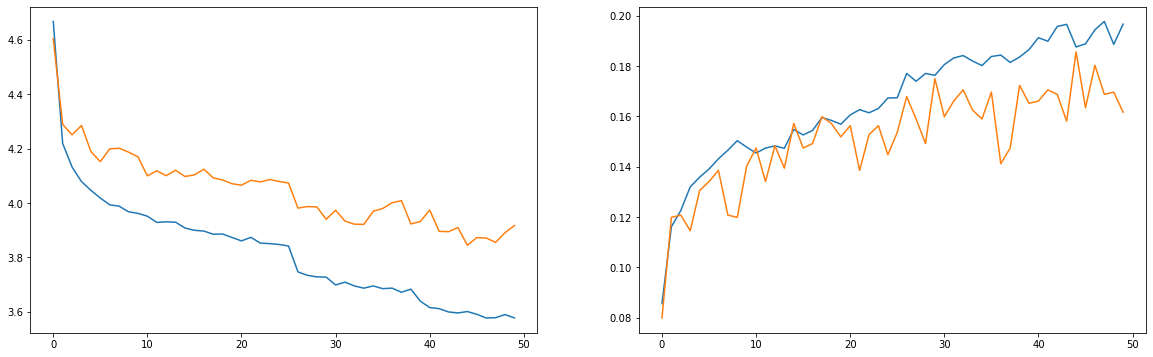

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history1.history['loss'])
axes[0].plot(history1.history['val_loss'])
axes[1].plot(history1.history['accuracy'])
axes[1].plot(history1.history['val_accuracy'])

In [16]:
history2 = model.fit(crop_train_generator, validation_data= crop_val_generator,epochs=50, verbose=True)

Epoch 1/50
331/331 [==============================] - 228s 688ms/step - loss: 3.5073 - accuracy: 0.2053 - top_k_categorical_accuracy: 0.4422 - val_loss: 3.8120 - val_accuracy: 0.1705 - val_top_k_categorical_accuracy: 0.3845
Epoch 2/50
331/331 [==============================] - 224s 678ms/step - loss: 3.5050 - accuracy: 0.2070 - top_k_categorical_accuracy: 0.4479 - val_loss: 3.8824 - val_accuracy: 0.1572 - val_top_k_categorical_accuracy: 0.3641
Epoch 3/50
331/331 [==============================] - 233s 704ms/step - loss: 3.5054 - accuracy: 0.2014 - top_k_categorical_accuracy: 0.4461 - val_loss: 3.8191 - val_accuracy: 0.1794 - val_top_k_categorical_accuracy: 0.3801
Epoch 4/50
331/331 [==============================] - 259s 781ms/step - loss: 3.5150 - accuracy: 0.2018 - top_k_categorical_accuracy: 0.4418 - val_loss: 3.8243 - val_accuracy: 0.1732 - val_top_k_categorical_accuracy: 0.3712
Epoch 5/50
331/331 [==============================] - 239s 722ms/step - loss: 3.5129 - accuracy: 0.2085 

331/331 [==============================] - 328s 991ms/step - loss: 3.4715 - accuracy: 0.2076 - top_k_categorical_accuracy: 0.4548 - val_loss: 3.8215 - val_accuracy: 0.1794 - val_top_k_categorical_accuracy: 0.3801
Epoch 38/50
331/331 [==============================] - 331s 1000ms/step - loss: 3.4668 - accuracy: 0.2132 - top_k_categorical_accuracy: 0.4516 - val_loss: 3.8139 - val_accuracy: 0.1856 - val_top_k_categorical_accuracy: 0.3766
Epoch 39/50
331/331 [==============================] - 370s 1s/step - loss: 3.4678 - accuracy: 0.2140 - top_k_categorical_accuracy: 0.4564 - val_loss: 3.8186 - val_accuracy: 0.1865 - val_top_k_categorical_accuracy: 0.3721
Epoch 40/50
331/331 [==============================] - 385s 1s/step - loss: 3.4695 - accuracy: 0.2059 - top_k_categorical_accuracy: 0.4564 - val_loss: 3.8363 - val_accuracy: 0.1838 - val_top_k_categorical_accuracy: 0.3677
Epoch 41/50
331/331 [==============================] - 326s 985ms/step - loss: 3.4674 - accuracy: 0.2123 - top_k_cate

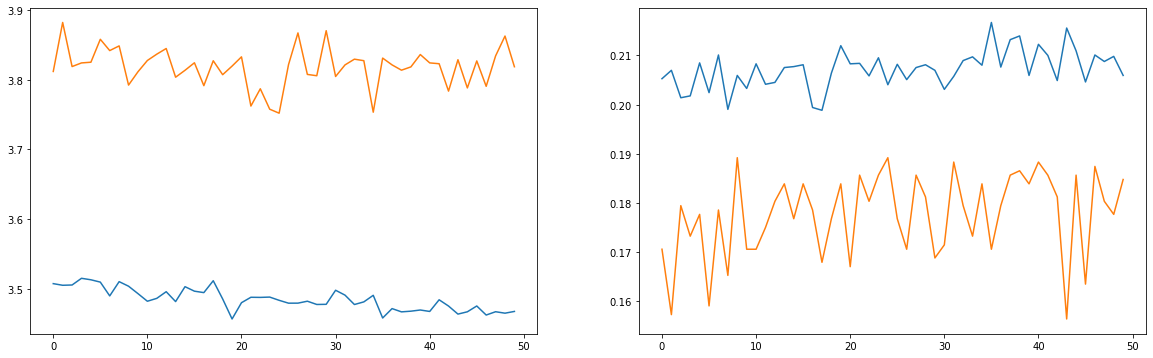

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history2.history['loss'])
axes[0].plot(history2.history['val_loss'])
axes[1].plot(history2.history['accuracy'])
axes[1].plot(history2.history['val_accuracy'])

In [18]:
history3 =model.fit(crop_train_generator, validation_data= crop_val_generator, epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
331/331 [==============================] - 230s 695ms/step - loss: 3.4626 - accuracy: 0.2116 - top_k_categorical_accuracy: 0.4596 - val_loss: 3.7910 - val_accuracy: 0.1785 - val_top_k_categorical_accuracy: 0.3828
Epoch 2/50
331/331 [==============================] - 241s 728ms/step - loss: 3.4660 - accuracy: 0.2094 - top_k_categorical_accuracy: 0.4514 - val_loss: 3.7830 - val_accuracy: 0.1847 - val_top_k_categorical_accuracy: 0.3783
Epoch 3/50
331/331 [==============================] - 260s 785ms/step - loss: 3.4792 - accuracy: 0.2091 - top_k_categorical_accuracy: 0.4562 - val_loss: 3.7919 - val_accuracy: 0.1892 - val_top_k_categorical_accuracy: 0.3721
Epoch 4/50
331/331 [==============================] - 270s 814ms/step - loss: 3.4605 - accuracy: 0.2107 - top_k_categorical_accuracy: 0.4613 - val_loss: 3.8098 - val_accuracy: 0.1723 - val_top_k_categorical_accuracy: 0.3774
Epoch 5/50
331/331 [==============================] - 272s 823ms/step - loss: 3.4749 - accuracy: 0.2115 

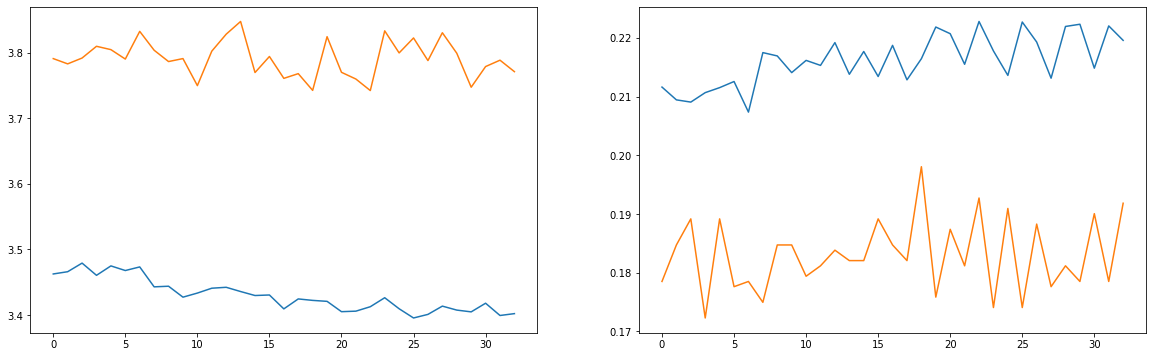

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history3.history['loss'])
axes[0].plot(history3.history['val_loss'])
axes[1].plot(history3.history['accuracy'])
axes[1].plot(history3.history['val_accuracy'])

## Test on raw dataset without augmentation

In [20]:
no_augment_datagen=ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

train_crop_no_augment = no_augment_datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,128))

test_crop_no_augment = no_augment_datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/test_crop",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,128),
    subset='training')

Found 11688 images belonging to 100 classes.
Found 2922 images belonging to 100 classes.


In [21]:
model.evaluate(train_crop_no_augment)

366/366 [==============================] - 224s 612ms/step - loss: 3.1400 - accuracy: 0.2735 - top_k_categorical_accuracy: 0.5474


[3.139958143234253, 0.27352839708328247, 0.5473990440368652]

In [22]:
model.evaluate(test_crop_no_augment)

92/92 [==============================] - 58s 631ms/step - loss: 3.4748 - accuracy: 0.2252 - top_k_categorical_accuracy: 0.4678


[3.474841356277466, 0.2251882255077362, 0.46783024072647095]

In [23]:
model.save('uec100')

INFO:tensorflow:Assets written to: uec100/assets


## Accuracy measures

In [24]:
ytrue =test_crop_no_augment.classes

In [25]:
ypred = model.predict(test_crop_no_augment)

In [26]:
ypred_label = [np.argmax(pred) for pred in ypred]

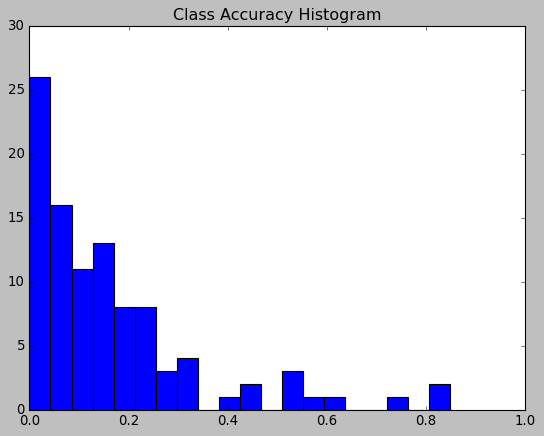

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
matrix = confusion_matrix(ytrue, ypred_label)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
plt.style.use('classic')
plt.title('Class Accuracy Histogram')
p = plt.hist(class_accuracies, bins=20)


In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(100):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(ytrue))[:, i], ypred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<ipython-input-29-01e6c4c82fe8>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


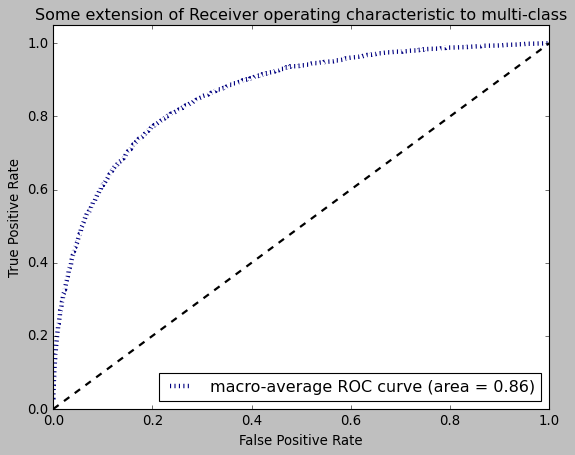

In [29]:
from scipy import interp
from itertools import cycle
lw = 2
n_classes = 100


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

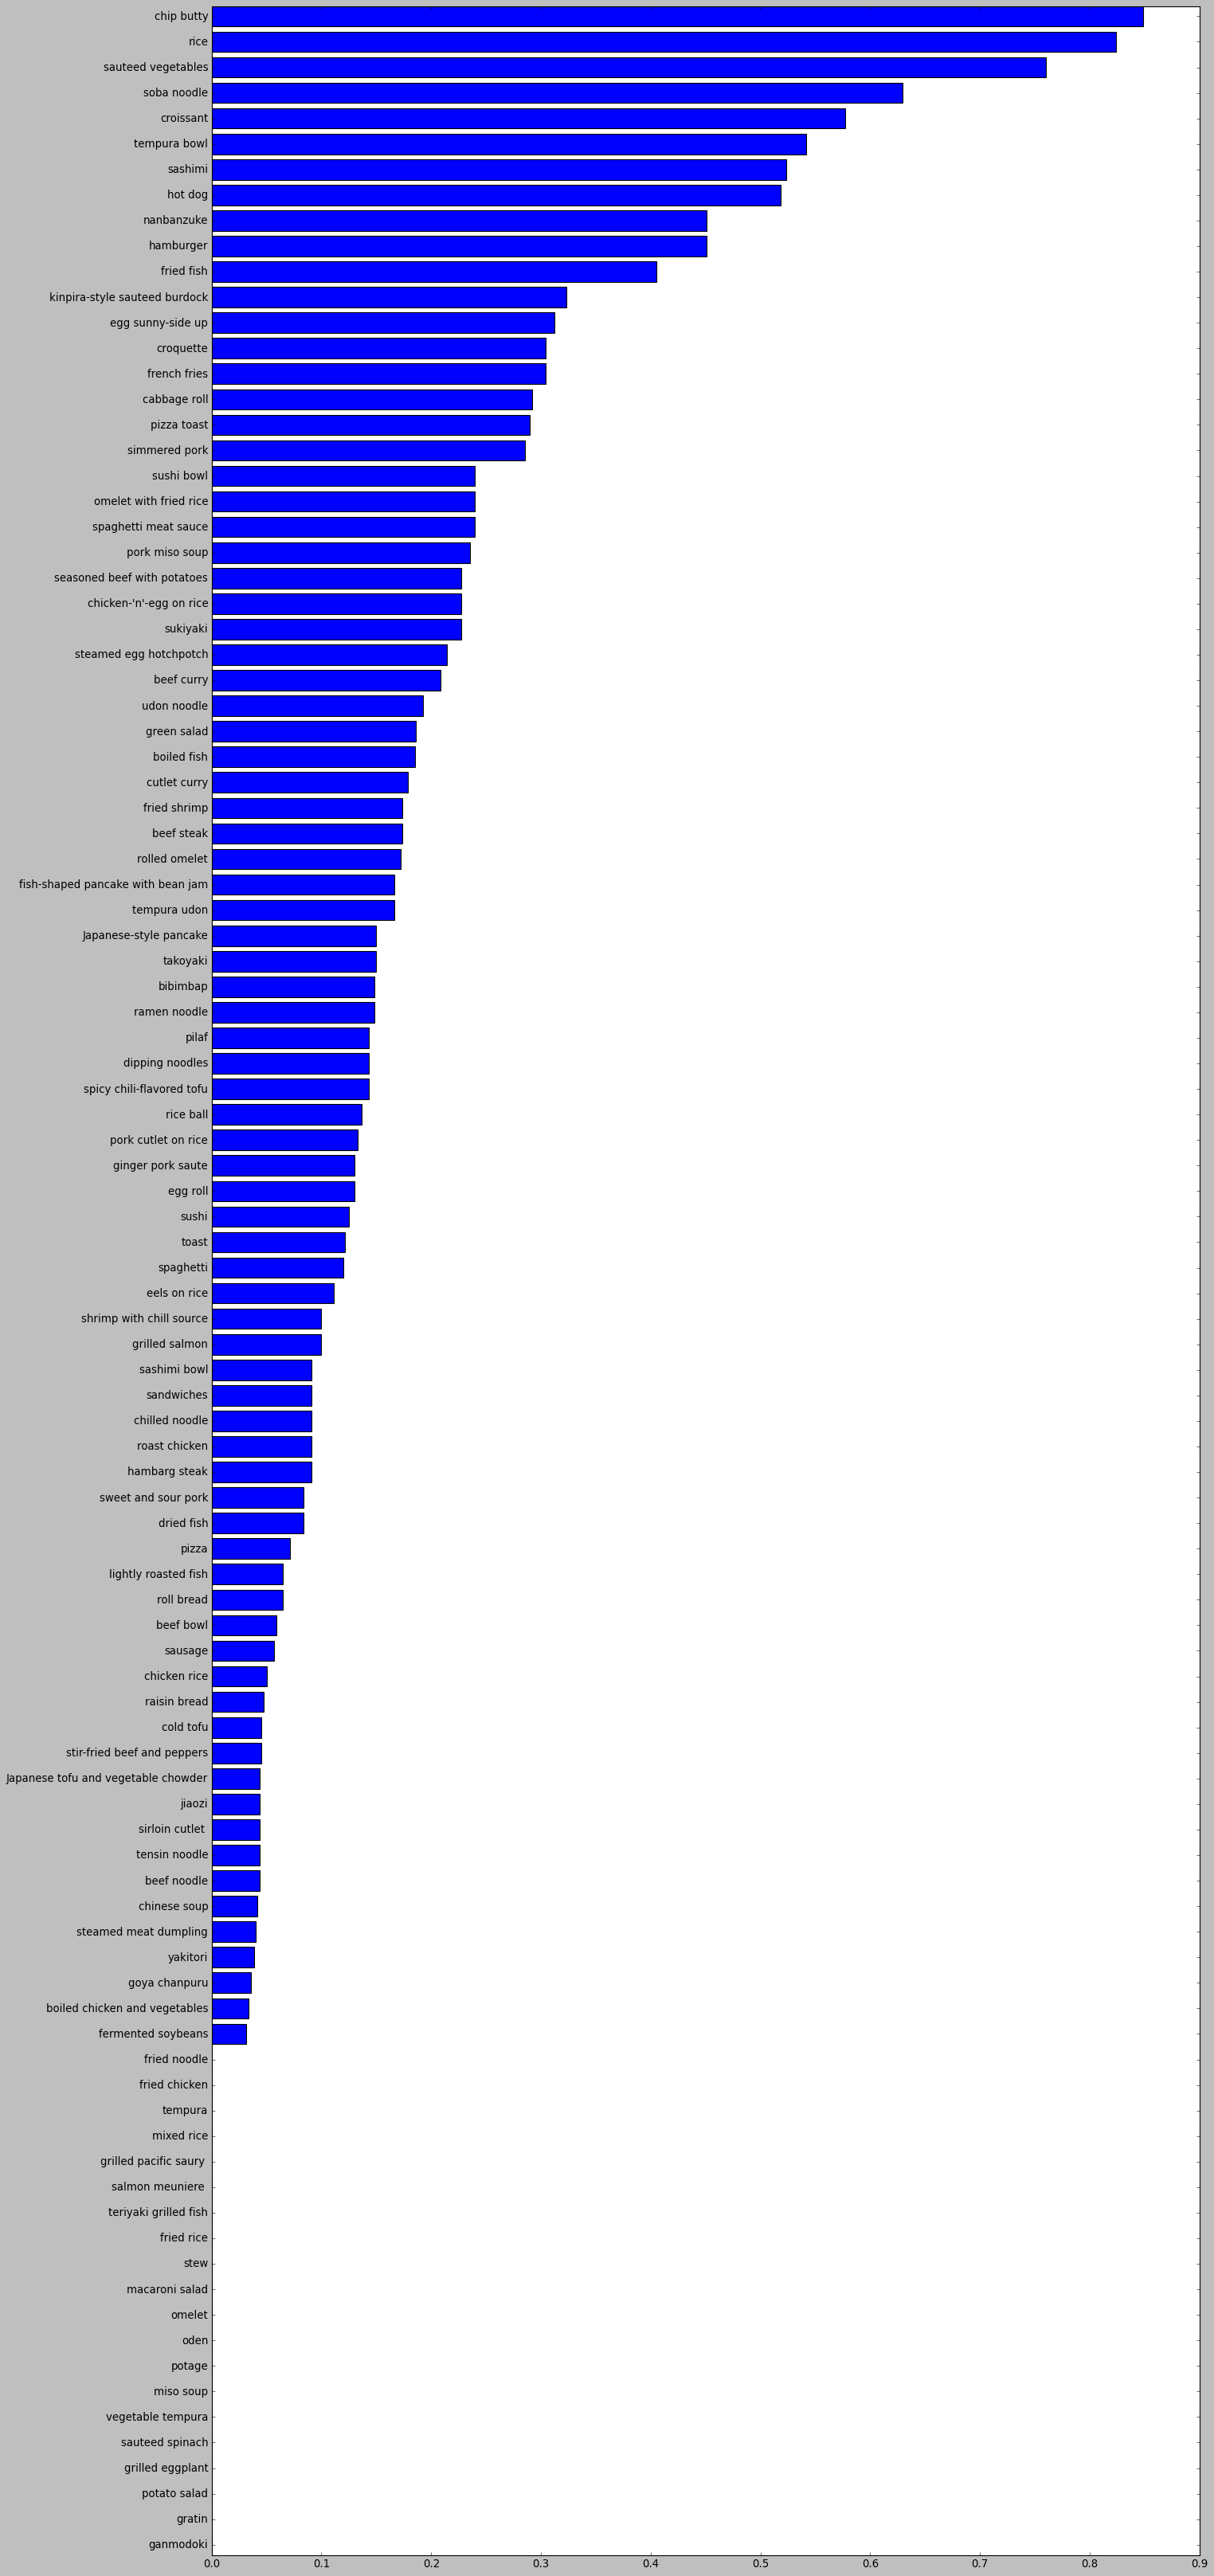

In [32]:
class_labels = pd.read_csv('UECFOOD100_CROP/category.txt', sep='\t')
acc = class_labels.join(pd.DataFrame(class_accuracies)).rename(columns={0:'class_accuracy'}).sort_values('class_accuracy')
plt.figure(figsize=(20,50))
p = plt.barh(acc.name, acc.class_accuracy)

In [33]:
acc

,id,name,class_accuracy
40,41,ganmodoki,0.000000
29,30,gratin,0.000000
85,86,potato salad,0.000000
32,33,grilled eggplant,0.000000
33,34,sauteed spinach,0.000000
...,...,...,...
12,13,croissant,0.576923
21,22,soba noodle,0.629630
30,31,sauteed vegetables,0.760274
0,1,rice,0.824000


## Try random images

In [34]:
class_labels.sort_values('id')

,id,name
0,1,rice
1,2,eels on rice
2,3,pilaf
3,4,chicken-'n'-egg on rice
4,5,pork cutlet on rice
...,...,...
95,96,dipping noodles
96,97,hot dog
97,98,french fries
98,99,mixed rice


In [37]:
import imagedata

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
text_labels = imagedata[['foodclass']].astype(str).drop_duplicates().set_index('foodclass').join(class_labels.astype(str).set_index('id'))
text_labels

TypeError: 'module' object is not subscriptable

In [36]:
img =load_img('web_pics/friedrice.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

NameError: name 'text_labels' is not defined

In [ ]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

In [ ]:
img =load_img('web_pics/unagi.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

In [ ]:
img =load_img('web_pics/pilaf.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

In [ ]:
img = load_img('web_pics/crossaint.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

## Convert Classifier to Object Detector

In [ ]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w,w))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [ ]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.1):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = area

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [ ]:
def detect_food(img):
    WIDTH = 128
    PYR_SCALE = 1.5
    WIN_STEP = 16
    ROI_SIZE = (128,128)
    INPUT_SIZE = (128, 128)
    rois = []
    locs = []
    (H, W) = img.shape[:2]
    pyramid = image_pyramid(img, minSize=(128,128))
    for image in pyramid:
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            
    import time
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs and print how long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    
    bbox_predictions = {}

    for i, p in enumerate(preds):
        # grab the prediction information for the current ROI
        predicted_label = np.argmax(p)

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if p[predicted_label] >= 0.995:

            # grab the bounding box associated with the prediction and
            # convert the coordinates
            box = locs[i]
            predicted_label_text = text_labels.iloc[predicted_label][0]

            L = bbox_predictions.get(predicted_label_text, [])
            L.append((box, p[predicted_label]))
            bbox_predictions[predicted_label_text] = L
    
    clone = img.copy()

    for item in bbox_predictions.keys():
        
        boxes = np.array([p[0] for p in bbox_predictions[item]])
        proba = np.array([p[1] for p in bbox_predictions[item]])
        boxes = non_max_suppression(boxes,proba)
        
        print('[FOOD DETECTED] ' +  item + ' ' + str(proba.max()))
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, item, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            break
            
    plt.imshow(np.clip(clone, a_max = 1, a_min=0))


In [ ]:
img = load_img('web_pics/jpfood.jpg')
img = img_to_array(img)/255
detect_food(img)

In [ ]:
img = load_img('web_pics/setmeal.jpg')
img = img_to_array(img)/255
detect_food(img)

In [ ]:
food_dict = {'french fries': {'protein': 0, 'carb': 20, 'fat': 999}}

[INFO] classifying ROIs...
[INFO] classifying ROIs took 6.88099 seconds
[FOOD DETECTED] french fries 0.99998045
[FOOD DETECTED] hamburger 0.99997056


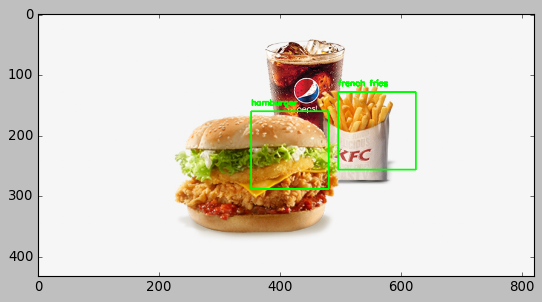

In [111]:
img = load_img('web_pics/fastfood_meal.jpg')
img = img_to_array(img)/255
detect_food(img)

[INFO] classifying ROIs...
[INFO] classifying ROIs took 2.58433 seconds
[FOOD DETECTED] croissant 1.0


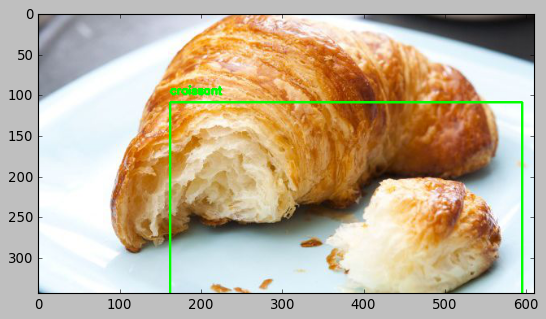

In [765]:
img = load_img('web_pics/crossaint.jpg')
img = img_to_array(img)/255
detect_food(img)